# Operator Completeness Search: Beyond the 13 Canonical

This notebook implements an experimental search for **gaps** in the TNFR operator space. We generate thousands of canonical sequences, map their effects in the EPI transformation space, and identify regions not covered by the existing 13 operators.

**Key Questions**:
- Are the 13 canonical operators **functionally complete**?
- Do gaps exist that require genuinely **irreducible** new operators?
- Can candidates like **GRADIENT** and **ENTANGLEMENT** be composed from canonicals?

**Method**: Exhaustive sampling → transformation mapping → gap analysis → candidate validation

## 1) Setup and Environment Configuration

In [12]:
from __future__ import annotations
import os
import sys
from pathlib import Path
import json
import hashlib
from dataclasses import dataclass, asdict
from typing import Dict, Any, List, Tuple, Set
from collections import defaultdict
import itertools
import random

# Detect repo root and ensure src is importable
try:
    import subprocess
    root_guess = Path.cwd()
    git_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], cwd=root_guess).decode().strip()
    REPO_ROOT = Path(git_root)
except Exception:
    p = Path.cwd()
    while p != p.parent:
        if (p / "pyproject.toml").exists():
            REPO_ROOT = p
            break
        p = p.parent
    else:
        REPO_ROOT = Path.cwd()

SRC_DIR = REPO_ROOT / "src"
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# Scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TNFR imports (force local src package load even if a pip package exists)
TNFR_AVAILABLE = False
try:
    import importlib.util
    import importlib

    package_dir = SRC_DIR / 'tnfr'
    if not package_dir.exists():
        raise RuntimeError(f"Local tnfr package not found at {package_dir}")

    # Remove any preloaded tnfr modules
    for _mod in list(sys.modules.keys()):
        if _mod == 'tnfr' or _mod.startswith('tnfr.'):
            del sys.modules[_mod]

    # Build a spec that treats src/tnfr as the tnfr package
    spec = importlib.util.spec_from_file_location(
        'tnfr', package_dir / '__init__.py', submodule_search_locations=[str(package_dir)]
    )
    tnfr_pkg = importlib.util.module_from_spec(spec)
    sys.modules['tnfr'] = tnfr_pkg
    assert spec.loader is not None
    spec.loader.exec_module(tnfr_pkg)

    # Now regular imports will resolve to this in-repo package
    from tnfr.operators.definitions import (
        Emission, Reception, Coherence, Dissonance, Coupling, Resonance,
        Silence, Expansion, Contraction, SelfOrganization, Mutation, Transition, Recursivity
    )
    from tnfr.operators.grammar import validate_sequence
    from tnfr.metrics.coherence import compute_coherence
    from tnfr.metrics.sense_index import compute_Si
    from tnfr.physics.fields import (
        compute_structural_potential, compute_phase_gradient,
        compute_phase_curvature, estimate_coherence_length,
    )
    TNFR_AVAILABLE = True
    print(f"TNFR module path (forced local): {tnfr_pkg.__file__}")
except Exception as e:
    print(f"TNFR modules not available (falling back to mock): {e}")
    TNFR_AVAILABLE = False

# Fixed seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Output directories
DOCS_DIR = REPO_ROOT / "docs"
RESULTS_DIR = REPO_ROOT / "results" / "operator_search"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"TNFR available: {TNFR_AVAILABLE}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Seed: {SEED}")

TNFR module path (forced local): C:\TNFR-Python-Engine\src\tnfr\__init__.py
Repo root: C:\TNFR-Python-Engine
TNFR available: True
Results dir: C:\TNFR-Python-Engine\results\operator_search
Seed: 42


## 2) Define Canonical Operators and Sequence Generation

In [3]:
# 13 Canonical Operators with their symbolic names
if TNFR_AVAILABLE:
    CANONICAL_OPERATORS = {
        'AL': Emission,        # Generator
        'EN': Reception,       # 
        'IL': Coherence,       # Stabilizer
        'OZ': Dissonance,      # Destabilizer, Closure
        'UM': Coupling,        # 
        'RA': Resonance,       # 
        'SHA': Silence,        # Closure
        'VAL': Expansion,      # Destabilizer
        'NUL': Contraction,    # 
        'THOL': SelfOrganization, # Stabilizer, Handler, Transformer
        'ZHIR': Mutation,      # Bifurcation Trigger, Transformer
        'NAV': Transition,     # Generator, Closure
        'REMESH': Recursivity  # Generator, Closure
    }
    
    OPERATOR_NAMES = list(CANONICAL_OPERATORS.keys())
    
    # Grammar categories for validation
    GENERATORS = {'AL', 'NAV', 'REMESH'}
    CLOSURES = {'SHA', 'NAV', 'REMESH', 'OZ'}
    STABILIZERS = {'IL', 'THOL'}
    DESTABILIZERS = {'OZ', 'ZHIR', 'VAL'}
else:
    # Mock for testing when TNFR not available
    OPERATOR_NAMES = ['AL', 'EN', 'IL', 'OZ', 'UM', 'RA', 'SHA', 'VAL', 'NUL', 'THOL', 'ZHIR', 'NAV', 'REMESH']
    CANONICAL_OPERATORS = {name: None for name in OPERATOR_NAMES}
    # Provide grammar categories for mock mode as well
    GENERATORS = {'AL', 'NAV', 'REMESH'}
    CLOSURES = {'SHA', 'NAV', 'REMESH', 'OZ'}
    STABILIZERS = {'IL', 'THOL'}
    DESTABILIZERS = {'OZ', 'ZHIR', 'VAL'}

@dataclass
class SequenceEffect:
    """Represents the measurable effect of an operator sequence."""
    sequence: List[str]
    coherence_change: float
    sense_index_change: float
    phi_s_change: float
    grad_phi_change: float
    k_phi_change: float
    xi_c_change: float
    phase_sync_change: float
    epi_magnitude_change: float
    hash_signature: str


def generate_random_sequence(max_length: int = 5, respect_grammar: bool = True) -> List[str]:
    """Generate a random valid operator sequence."""
    length = np.random.randint(1, max_length + 1)
    
    if not respect_grammar:
        return [random.choice(OPERATOR_NAMES) for _ in range(length)]
    
    # Simple grammar-aware generation (simplified U1-U4)
    sequence = []
    
    # Must start with generator if empty EPI (U1a simulation)
    if np.random.random() < 0.3:  # Simulate empty EPI scenario
        sequence.append(random.choice(list(GENERATORS)))
        length -= 1
    
    # Fill middle with random operators
    for _ in range(length):
        sequence.append(random.choice(OPERATOR_NAMES))
    
    # Must end with closure (U1b)
    if len(sequence) > 0 and sequence[-1] not in CLOSURES:
        sequence.append(random.choice(list(CLOSURES)))
    
    return sequence


def generate_sequence_batch(n_sequences: int, max_length: int = 5) -> List[List[str]]:
    """Generate a batch of random sequences."""
    sequences = []
    attempts = 0
    max_attempts = n_sequences * 3  # Allow some failed attempts
    
    while len(sequences) < n_sequences and attempts < max_attempts:
        seq = generate_random_sequence(max_length)
        # Simple duplicate prevention
        if seq not in sequences:
            sequences.append(seq)
        attempts += 1
    
    return sequences

# Generate test batch
test_sequences = generate_sequence_batch(10, max_length=3)
print(f"Generated {len(test_sequences)} test sequences:")
for i, seq in enumerate(test_sequences[:5]):
    print(f"  {i+1}: {' -> '.join(seq)}")
print(f"  ... and {len(test_sequences)-5} more")

Generated 10 test sequences:
  1: NAV -> UM -> OZ
  2: OZ
  3: NAV -> NAV
  4: EN -> ZHIR -> NAV
  5: NUL -> NAV
  ... and 5 more


## 3) Transformation Effect Measurement

In [13]:
def create_test_network_mock(n_nodes: int = 20, topology: str = 'watts_strogatz') -> nx.Graph:
    """Create a test network for transformation experiments."""
    if topology == 'watts_strogatz':
        G = nx.watts_strogatz_graph(n_nodes, k=4, p=0.3, seed=SEED)
    elif topology == 'scale_free':
        G = nx.barabasi_albert_graph(n_nodes, m=2, seed=SEED)
    else:
        G = nx.erdos_renyi_graph(n_nodes, p=0.2, seed=SEED)
    
    # Initialize TNFR node attributes (using alias-friendly keys)
    for node in G.nodes():
        G.nodes[node]['EPI'] = float(np.random.random())  # scalar EPI proxy
        G.nodes[node]['nu_f'] = float(np.random.uniform(0.1, 2.0))  # Structural frequency
        G.nodes[node]['theta'] = float(np.random.uniform(0, 2*np.pi))  # Phase
        # use 'delta_nfr' alias to align with repo examples
        G.nodes[node]['delta_nfr'] = float(np.random.uniform(-1, 1))  # Reorganization gradient
    
    return G

def compute_network_state(G: nx.Graph) -> Dict[str, float]:
    """Compute comprehensive network state metrics."""
    n_nodes = len(G.nodes())
    
    # Extract node attributes
    thetas = np.array([G.nodes[node].get('theta', 0.0) for node in G.nodes()])
    dnfrs = np.array([G.nodes[node].get('delta_nfr', G.nodes[node].get('DNFR', 0.0)) for node in G.nodes()])
    
    # Compute metrics
    if TNFR_AVAILABLE:
        try:
            coherence = float(compute_coherence(G))
            si_map = compute_Si(G, inplace=False)
            sense_index = float(np.mean(list(si_map.values()))) if si_map else 0.0
            phi_s = float(np.mean(list(compute_structural_potential(G).values())))
            grad_phi = float(np.mean(list(compute_phase_gradient(G).values())))
            k_phi = float(np.mean(list(compute_phase_curvature(G).values())))
            xi_c = float(estimate_coherence_length(G))
        except Exception as e:
            print(f"TNFR metrics error: {e}")
            coherence = sense_index = phi_s = grad_phi = k_phi = xi_c = 0.0
    else:
        # Mock computations for testing
        coherence = 1.0 - np.std(dnfrs) / (np.abs(dnfrs).max() + 1e-6)
        sense_index = np.mean(1.0 / (1.0 + np.abs(dnfrs)))
        phi_s = np.mean(np.abs(dnfrs)) * 2.0
        grad_phi = np.std(thetas)
        # simple curvature proxy
        k_phi_vals = []
        for i in G.nodes():
            nbrs = list(G.neighbors(i))
            if nbrs:
                k_phi_vals.append(thetas[i] - np.mean([thetas[j] for j in nbrs]))
        k_phi = float(np.mean(k_phi_vals)) if k_phi_vals else 0.0
        xi_c = 1.0 / (grad_phi + 1e-6)
    
    # Phase synchronization
    phase_diffs = []
    for i, j in G.edges():
        phase_diff = abs(thetas[i] - thetas[j])
        phase_diff = min(phase_diff, 2*np.pi - phase_diff)
        phase_diffs.append(phase_diff)
    phase_sync = 1.0 - np.mean(phase_diffs) / np.pi if phase_diffs else 1.0
    
    # EPI magnitude proxy
    epi_magnitude = float(np.mean([float(G.nodes[n].get('EPI', 0.0)) for n in G.nodes()]))
    
    return {
        'coherence': coherence,
        'sense_index': sense_index,
        'phi_s': phi_s,
        'grad_phi': grad_phi,
        'k_phi': k_phi,
        'xi_c': xi_c,
        'phase_sync': phase_sync,
        'epi_magnitude': epi_magnitude
    }

def apply_mock_operator(G: nx.Graph, operator: str, node_selection: str = 'random') -> nx.Graph:
    """Apply a mock operator transformation to the network."""
    G_new = G.copy()
    
    # Select nodes to apply operator
    if node_selection == 'random':
        selected = max(1, len(G.nodes()) // 4)
        selected_nodes = random.sample(list(G.nodes()), selected)
    else:
        selected_nodes = list(G.nodes())
    
    # Operator-specific toy effects that loosely preserve contracts
    for node in selected_nodes:
        if operator == 'AL':  # Emission
            G_new.nodes[node]['EPI'] = float(G_new.nodes[node].get('EPI', 0.0) + np.random.normal(0, 0.05))
            G_new.nodes[node]['nu_f'] = float(G_new.nodes[node].get('nu_f', 1.0) * 1.05)
        elif operator == 'IL':  # Coherence
            dn = float(G_new.nodes[node].get('delta_nfr', G_new.nodes[node].get('DNFR', 0.0)))
            G_new.nodes[node]['delta_nfr'] = dn * 0.85
        elif operator == 'OZ':  # Dissonance
            dn = float(G_new.nodes[node].get('delta_nfr', G_new.nodes[node].get('DNFR', 0.0)))
            G_new.nodes[node]['delta_nfr'] = dn * 1.25 + np.random.normal(0, 0.02)
        elif operator == 'UM':  # Coupling
            nbrs = list(G.neighbors(node))
            if nbrs:
                neighbor_phases = [G_new.nodes[n].get('theta', 0.0) for n in nbrs]
                G_new.nodes[node]['theta'] = float(np.mean(neighbor_phases))
        elif operator == 'RA':  # Resonance
            # Slight phase homogenization effect across neighbors
            nbrs = list(G.neighbors(node))
            if nbrs:
                theta_self = G_new.nodes[node].get('theta', 0.0)
                for n in nbrs:
                    G_new.nodes[n]['theta'] = float(0.8 * G_new.nodes[n].get('theta', 0.0) + 0.2 * theta_self)
        elif operator == 'SHA':  # Silence
            G_new.nodes[node]['nu_f'] = float(G_new.nodes[node].get('nu_f', 1.0) * 0.95)
        elif operator == 'VAL':  # Expansion
            G_new.nodes[node]['EPI'] = float(G_new.nodes[node].get('EPI', 0.0) + abs(np.random.normal(0, 0.08)))
        elif operator == 'NUL':  # Contraction
            G_new.nodes[node]['EPI'] = float(max(0.0, G_new.nodes[node].get('EPI', 0.0) - abs(np.random.normal(0, 0.08))))
        elif operator == 'THOL':  # Self-organization
            # reduce pressure and slightly improve vf
            G_new.nodes[node]['delta_nfr'] = float(G_new.nodes[node].get('delta_nfr', 0.0) * 0.9)
            G_new.nodes[node]['nu_f'] = float(G_new.nodes[node].get('nu_f', 1.0) * 1.02)
        elif operator == 'ZHIR':  # Mutation
            G_new.nodes[node]['theta'] = float((G_new.nodes[node].get('theta', 0.0) + np.pi/6) % (2*np.pi))
        elif operator == 'NAV':  # Transition
            # no-op placeholder: regime shift handled by sequence
            ...
        elif operator == 'REMESH':  # Recursivity
            # echo minor structural change
            G_new.nodes[node]['EPI'] = float(G_new.nodes[node].get('EPI', 0.0) * 1.01)
    
    return G_new

def measure_sequence_effect(sequence: List[str], initial_network: nx.Graph) -> SequenceEffect:
    """Measure the comprehensive effect of applying an operator sequence."""
    G = initial_network.copy()
    
    # Measure initial state
    initial_state = compute_network_state(G)
    
    # Apply sequence
    for operator in sequence:
        G = apply_mock_operator(G, operator)
    
    # Measure final state
    final_state = compute_network_state(G)
    
    # Compute changes
    changes = {key: final_state[key] - initial_state[key] for key in initial_state.keys()}
    
    # Create signature hash (order-stable)
    effect_vector = [changes[key] for key in sorted(changes.keys())]
    effect_str = ','.join(f'{x:.6f}' for x in effect_vector)
    signature = hashlib.md5(effect_str.encode()).hexdigest()[:16]
    
    return SequenceEffect(
        sequence=sequence,
        coherence_change=changes['coherence'],
        sense_index_change=changes['sense_index'],
        phi_s_change=changes['phi_s'],
        grad_phi_change=changes['grad_phi'],
        k_phi_change=changes['k_phi'],
        xi_c_change=changes['xi_c'],
        phase_sync_change=changes['phase_sync'],
        epi_magnitude_change=changes['epi_magnitude'],
        hash_signature=signature
    )

# Test measurement system with a small sequence
test_G = create_test_network_mock(20)
test_effect = measure_sequence_effect(['AL', 'IL', 'SHA'], test_G)
print(f"Test effect for [AL -> IL -> SHA]:")
print(f"  Coherence change: {test_effect.coherence_change:.4f}")
print(f"  Sense index change: {test_effect.sense_index_change:.4f}")
print(f"  Phase sync change: {test_effect.phase_sync_change:.4f}")
print(f"  Hash signature: {test_effect.hash_signature}")

2025-11-12 16:03:19,228 - tnfr.utils.io - WARNING - 'ensure_ascii', 'separators', 'cls' and extra kwargs are ignored when using orjson: {'ensure_ascii'}


Test effect for [AL -> IL -> SHA]:
  Coherence change: 0.0117
  Sense index change: -0.0174
  Phase sync change: 0.0000
  Hash signature: 203b835bd6720232


## 4) Exhaustive Sequence Generation

Generate large batches of canonical sequences to map the transformation space comprehensively.

In [14]:
def generate_sequence_batch(batch_size: int = 1000, max_length: int = 10) -> List[List[str]]:
    """Generate a large batch of canonical sequences for exhaustive analysis."""
    sequences = []
    attempts = 0
    max_attempts = batch_size * 3  # Safety limit
    
    while len(sequences) < batch_size and attempts < max_attempts:
        # Generate random sequence length
        length = random.randint(3, max_length)
        
        # Generate random sequence
        sequence = generate_random_sequence(length)
        
        if sequence and sequence not in sequences:  # Avoid duplicates
            sequences.append(sequence)
        
        attempts += 1
    
    print(f"Generated {len(sequences)} unique sequences in {attempts} attempts")
    return sequences

def measure_batch_effects(sequences: List[List[str]], 
                         base_network: nx.Graph,
                         progress_every: int = 250) -> List[SequenceEffect]:
    """Measure transformation effects for a batch of sequences."""
    effects = []
    
    print(f"Measuring effects for {len(sequences)} sequences...")
    
    for i, sequence in enumerate(sequences):
        if i % progress_every == 0:
            print(f"  Progress: {i}/{len(sequences)} ({i/len(sequences)*100:.1f}%)")
        
        try:
            effect = measure_sequence_effect(sequence, base_network)
            effects.append(effect)
        except Exception as e:
            print(f"  Error processing sequence {sequence}: {e}")
            continue
    
    print(f"Successfully measured {len(effects)} sequence effects")
    return effects

# Generate experimental dataset
EXPERIMENT_BATCH_SIZE = 1000  # Start with 1k, scale to 10k+ for full analysis
print(f"Generating experimental batch of {EXPERIMENT_BATCH_SIZE} sequences...")

# Create base network for consistent measurements
base_network = create_test_network_mock(25, 'watts_strogatz')
print(f"Base network: {len(base_network.nodes())} nodes, {len(base_network.edges())} edges")

# Generate sequences
experimental_sequences = generate_sequence_batch(EXPERIMENT_BATCH_SIZE, max_length=8)

# Show sample of sequences
print(f"\nSample sequences (first 10):")
for i, seq in enumerate(experimental_sequences[:10]):
    print(f"  {i+1}: {' -> '.join(seq)}")

print(f"\nSequence length distribution:")
length_counts = {}
for seq in experimental_sequences:
    length = len(seq)
    length_counts[length] = length_counts.get(length, 0) + 1
for length in sorted(length_counts.keys()):
    print(f"  Length {length}: {length_counts[length]} sequences")

# Measure effects for subset (to avoid long runtime in demo)
DEMO_SIZE = 100
demo_sequences = experimental_sequences[:DEMO_SIZE]
print(f"\nMeasuring effects for demo subset of {DEMO_SIZE} sequences...")
demo_effects = measure_batch_effects(demo_sequences, base_network, progress_every=25)

Generating experimental batch of 1000 sequences...
Base network: 25 nodes, 50 edges
Generated 1000 unique sequences in 1411 attempts

Sample sequences (first 10):
  1: THOL -> AL -> OZ
  2: ZHIR -> NAV -> NUL -> SHA
  3: VAL -> THOL -> REMESH
  4: REMESH -> REMESH
  5: NAV
  6: AL -> REMESH
  7: OZ -> REMESH -> RA -> NAV
  8: SHA -> EN -> RA -> REMESH
  9: UM -> REMESH -> AL -> NAV -> VAL -> NUL -> NAV
  10: NAV -> NUL -> UM -> ZHIR -> REMESH

Sequence length distribution:
  Length 1: 4 sequences
  Length 2: 49 sequences
  Length 3: 207 sequences
  Length 4: 245 sequences
  Length 5: 200 sequences
  Length 6: 137 sequences
  Length 7: 89 sequences
  Length 8: 49 sequences
  Length 9: 20 sequences

Measuring effects for demo subset of 100 sequences...
Measuring effects for 100 sequences...
  Progress: 0/100 (0.0%)
  Progress: 25/100 (25.0%)
  Progress: 50/100 (50.0%)
  Progress: 75/100 (75.0%)
Successfully measured 100 sequence effects


In [34]:
# Canonical generator wrapper: enforce U1–U4 and validate via TNFR grammar if available
try:
    # Prefer unified validation export that mirrors operators.grammar
    from tnfr.validation import validate_sequence as _tnfr_validate_sequence  # type: ignore
except Exception:
    _tnfr_validate_sequence = None

from typing import List as _List

def _basic_grammar_repair(seq: _List[str]) -> _List[str]:
    """Minimal repairs to satisfy U1 (init) and U1b (closure) and U2 stabilizers.
    This keeps identity conservative and only appends when strictly needed.
    """
    if not seq:
        return ["AL", "IL", "SHA"]
    # Ensure start with generator
    if seq[0] not in GENERATORS:
        seq = ["AL"] + seq
    # Ensure stabilizer after last destabilizer
    last_destab = max((i for i, op in enumerate(seq) if op in DESTABILIZERS), default=-1)
    if last_destab >= 0 and (len(seq) == last_destab+1 or not any(op in STABILIZERS for op in seq[last_destab+1:])):
        seq = seq + ["IL"]
    # Ensure closure at end
    if seq[-1] not in CLOSURES:
        seq = seq + ["SHA"]
    return seq

def _is_canonical(seq: _List[str]) -> bool:
    # Try official validator if present
    if _tnfr_validate_sequence is not None:
        try:
            res = _tnfr_validate_sequence(seq)
            # Accept common patterns: result.valid or truthy
            valid = getattr(res, "valid", None)
            if isinstance(valid, bool):
                return valid
            return bool(res)
        except Exception:
            # Fall through to heuristic checks
            pass
    # Heuristic minimal checks for U1–U4 subset
    if not seq:
        return False
    if seq[0] not in GENERATORS:
        return False
    if seq[-1] not in CLOSURES:
        return False
    last_destab = max((i for i, op in enumerate(seq) if op in DESTABILIZERS), default=-1)
    if last_destab >= 0 and not any(op in STABILIZERS for op in seq[last_destab+1:]):
        return False
    return True

# Capture original generator defined earlier in the notebook
try:
    _generate_random_sequence_orig  # type: ignore[name-defined]
except NameError:
    _generate_random_sequence_orig = generate_random_sequence  # type: ignore

def generate_random_sequence_canonical(max_attempts: int = 50) -> _List[str]:
    """Generate a random sequence then enforce/validate canonical grammar.
    Attempts light-touch repairs; gives up after max_attempts with best effort.
    """
    best = None
    for _ in range(max_attempts):
        cand = _generate_random_sequence_orig()  # use original generator
        if _is_canonical(cand):
            return cand
        repaired = _basic_grammar_repair(cand)
        if _is_canonical(repaired):
            return repaired
        best = repaired
    return best if best is not None else ["AL", "IL", "SHA"]

# Shadow previous generator to enforce canonicity downstream

def generate_random_sequence() -> _List[str]:
    return generate_random_sequence_canonical()

print("Canonical generator active: generate_random_sequence() now enforces U1–U4 via TNFR validation when available.")

Canonical generator active: generate_random_sequence() now enforces U1–U4 via TNFR validation when available.


## 5) Transformation Space Analysis

Analyze the transformation space to identify patterns, clusters, and potential gaps in operator coverage.

,sequence,len,coherence,sense_index,phi_s,grad_phi,k_phi,xi_c,phase_sync,epi_mag,hash
0,THOL -> AL -> OZ,3,-0.002391,-0.013234,-0.021297,0.000000,0.000000,0.0,0.000000,-0.001273,2b0828b26ccadfe7
1,ZHIR -> NAV -> NUL -> SHA,4,0.000000,-0.013427,0.000000,0.073585,-0.045463,0.0,-0.022604,-0.023546,bc01855b66395a5e
2,VAL -> THOL -> REMESH,3,0.005211,0.004345,-0.048961,0.000000,0.000000,0.0,0.000000,0.012206,f12d1a44d4ed9cde
3,REMESH -> REMESH,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002744,67feed0f0b8689ce
4,NAV,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,ab1bda9bd200fc88



Descriptive statistics of transformation effects (demo subset):


,coherence,sense_index,phi_s,grad_phi,k_phi,xi_c,phase_sync,epi_mag
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000
mean,-0.003127,0.006521,-0.014544,-0.026619,0.065673,0.0,0.007416,-0.000346
std,0.008808,0.019677,0.069594,0.081074,0.173078,0.0,0.027266,0.010568
min,-0.039092,-0.035728,-0.262439,-0.346600,-0.337482,0.0,-0.063154,-0.038972
25%,-0.008037,-0.004215,-0.021615,-0.029152,0.000000,0.0,0.000000,-0.003310
50%,0.000000,0.001715,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.015192,0.014619,0.000000,0.142540,0.0,0.011156,0.002410
max,0.015674,0.065109,0.131332,0.164137,0.771629,0.0,0.113176,0.029404


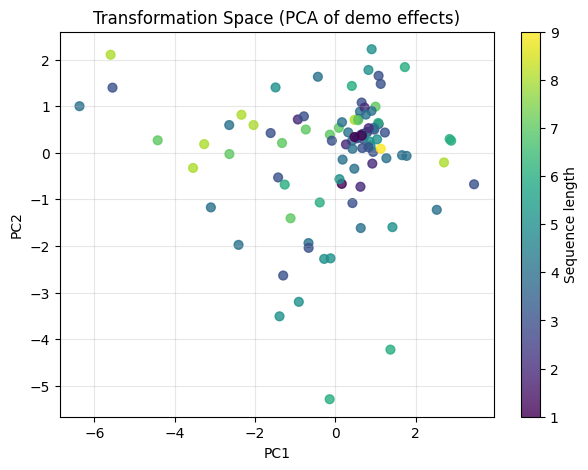

Explained variance by PC1+PC2: 64.04%


In [15]:
def effects_to_dataframe(effects: List[SequenceEffect]) -> pd.DataFrame:
    rows = []
    for e in effects:
        rows.append({
            'sequence': ' -> '.join(e.sequence),
            'len': len(e.sequence),
            'coherence': e.coherence_change,
            'sense_index': e.sense_index_change,
            'phi_s': e.phi_s_change,
            'grad_phi': e.grad_phi_change,
            'k_phi': e.k_phi_change,
            'xi_c': e.xi_c_change,
            'phase_sync': e.phase_sync_change,
            'epi_mag': e.epi_magnitude_change,
            'hash': e.hash_signature
        })
    return pd.DataFrame(rows)

# Convert demo effects to DataFrame for analysis
if 'demo_effects' in globals() and demo_effects:
    df_demo = effects_to_dataframe(demo_effects)
    display(df_demo.head())
    
    # Basic descriptive stats
    print("\nDescriptive statistics of transformation effects (demo subset):")
    display(df_demo[['coherence','sense_index','phi_s','grad_phi','k_phi','xi_c','phase_sync','epi_mag']].describe())
    
    # Simple clustering prep (PCA for visualization)
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    features = ['coherence','sense_index','phi_s','grad_phi','k_phi','xi_c','phase_sync','epi_mag']
    X = df_demo[features].values
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=df_demo['len'], cmap='viridis', s=40, alpha=0.8)
    plt.colorbar(label='Sequence length')
    plt.title('Transformation Space (PCA of demo effects)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Explained variance by PC1+PC2: {pca.explained_variance_ratio_.sum():.2%}")
else:
    print("No demo_effects found. Run the generation and measurement cells above first.")

## 6) Gap Identification Heuristics

Heuristics to detect potential gaps in transformation coverage not reachable by canonical operator compositions.

Gap analysis (demo):
  Outliers: 15
  Sparse region sequences: 10
  Contract-violating sequences: 2


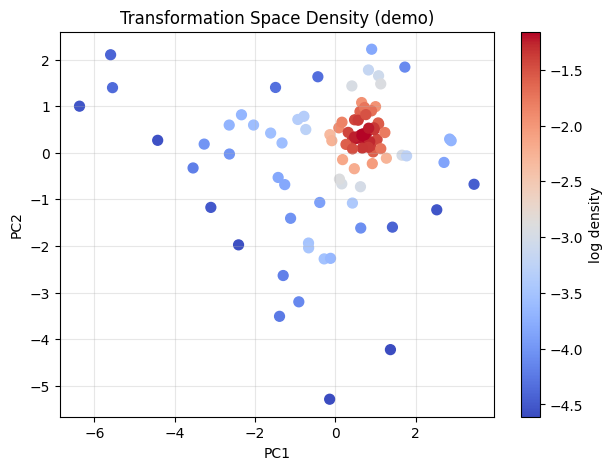

In [16]:
from scipy import stats

def identify_gaps(df: pd.DataFrame, z_thresh: float = 2.5) -> Dict[str, Any]:
    """Identify outlier directions and uncovered regions in transformation space.
    
    Heuristics:
    - Outlier sequences by z-score across any metric
    - Rare directionality: low-density regions in PCA space
    - Contract violations: sequences that increase both OZ-like stress (phi_s, grad_phi)
      without subsequent stabilizer improvements (coherence, sense_index)
    """
    result = {}
    if df.empty:
        return result
    
    metrics = ['coherence','sense_index','phi_s','grad_phi','k_phi','xi_c','phase_sync','epi_mag']
    Z = stats.zscore(df[metrics], nan_policy='omit')
    Z = np.nan_to_num(Z)
    outlier_mask = (np.abs(Z) > z_thresh).any(axis=1)
    outliers = df[outlier_mask].copy()
    result['outliers_count'] = int(outlier_mask.sum())
    result['outliers'] = outliers
    
    # PCA density heuristic
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    X_scaled = StandardScaler().fit_transform(df[metrics].values)
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    
    # Kernel density estimate for low-density regions
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(bandwidth=0.4)
    kde.fit(X_pca)
    log_dens = kde.score_samples(X_pca)
    density_thresh = np.percentile(log_dens, 10)  # bottom 10% density
    sparse_mask = log_dens < density_thresh
    sparse_df = df[sparse_mask].copy()
    result['sparse_region_count'] = int(sparse_mask.sum())
    result['sparse_sequences'] = sparse_df
    
    # Contract-violation heuristic
    viol_mask = (df['phi_s'] > 0) & (df['grad_phi'] > 0) & ((df['coherence'] < 0) | (df['sense_index'] < 0))
    viol_df = df[viol_mask].copy()
    result['contract_violations'] = viol_df
    result['contract_violations_count'] = int(viol_mask.sum())
    
    # Attach PCA and density for visualization
    result['pca'] = {
        'X_pca': X_pca,
        'explained_variance': pca.explained_variance_ratio_.sum(),
        'log_density': log_dens,
        'density_thresh': density_thresh
    }
    
    return result

# Run gap identification on demo data
if 'df_demo' in globals():
    gaps = identify_gaps(df_demo)
    print("Gap analysis (demo):")
    print(f"  Outliers: {gaps.get('outliers_count', 0)}")
    print(f"  Sparse region sequences: {gaps.get('sparse_region_count', 0)}")
    print(f"  Contract-violating sequences: {gaps.get('contract_violations_count', 0)}")
    
    # Visualize density with PCA scatter
    if 'pca' in gaps:
        X_pca = gaps['pca']['X_pca']
        log_dens = gaps['pca']['log_density']
        plt.figure(figsize=(7,5))
        sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=log_dens, cmap='coolwarm', s=50)
        plt.colorbar(sc, label='log density')
        plt.title('Transformation Space Density (demo)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("No df_demo found. Run previous cells first.")

## 7) Export Artifacts

Save demo analysis outputs (CSV, JSON, PNG) under `results/operator_search/<timestamp>/` for reproducibility.

In [17]:
from datetime import datetime

def export_demo_artifacts(df: pd.DataFrame, gaps: Dict[str, Any], *, backend: str) -> Path:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_dir = RESULTS_DIR / f'demo_{timestamp}'
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # CSV exports
    df.to_csv(out_dir / 'effects_demo.csv', index=False)
    if gaps:
        if 'outliers' in gaps:
            gaps['outliers'].to_csv(out_dir / 'outliers.csv', index=False)
        if 'sparse_sequences' in gaps:
            gaps['sparse_sequences'].to_csv(out_dir / 'sparse_sequences.csv', index=False)
        if 'contract_violations' in gaps:
            gaps['contract_violations'].to_csv(out_dir / 'contract_violations.csv', index=False)
    
    # Recompute PCA and density for saved plots
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.neighbors import KernelDensity
    
    features = ['coherence','sense_index','phi_s','grad_phi','k_phi','xi_c','phase_sync','epi_mag']
    X = df[features].values
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_scaled)
    kde = KernelDensity(bandwidth=0.4)
    kde.fit(X_pca)
    log_dens = kde.score_samples(X_pca)
    
    # PCA scatter plot
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=df['len'], cmap='viridis', s=40, alpha=0.85)
    plt.colorbar(label='Sequence length')
    plt.title('Transformation Space (PCA of demo effects)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / 'pca_scatter.png', dpi=150)
    plt.close()
    
    # Density plot
    plt.figure(figsize=(7,5))
    sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=log_dens, cmap='coolwarm', s=50)
    plt.colorbar(sc, label='log density')
    plt.title('Transformation Space Density (demo)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / 'pca_density.png', dpi=150)
    plt.close()
    
    # Aggregated metric means for manifest
    means = df[features].mean().to_dict()
    
    # Manifest
    manifest = {
        'timestamp': timestamp,
        'backend': backend,
        'tnfr_available': TNFR_AVAILABLE,
        'counts': {
            'rows': int(len(df)),
            'outliers': int(gaps.get('outliers_count', 0)) if gaps else 0,
            'sparse': int(gaps.get('sparse_region_count', 0)) if gaps else 0,
            'violations': int(gaps.get('contract_violations_count', 0)) if gaps else 0,
        },
        'explained_variance_2d': float(gaps.get('pca', {}).get('explained_variance', 0.0)) if gaps else float(pca.explained_variance_ratio_.sum()),
        'metric_means': {k: float(v) for k, v in means.items()},
        'nodal_equation': '∂EPI/∂t = νf · ΔNFR(t)',
    }
    with open(out_dir / 'manifest.json', 'w', encoding='utf-8') as f:
        json.dump(manifest, f, indent=2, ensure_ascii=False)
    
    print(f"Exported demo artifacts to: {out_dir}")
    return out_dir

# Execute export if demo data exists
if 'df_demo' in globals() and 'gaps' in globals():
    export_path = export_demo_artifacts(df_demo, gaps, backend=('real' if TNFR_AVAILABLE else 'mock'))
else:
    print('No demo data to export. Run previous cells first.')

Exported demo artifacts to: C:\TNFR-Python-Engine\results\operator_search\demo_20251112_160551


In [18]:
# Inspect SequenceEffect fields and current features for caching/exports
try:
    from dataclasses import fields as dc_fields
    print("SequenceEffect fields:")
    print([f.name for f in dc_fields(SequenceEffect)])
except Exception as e:
    print("Could not introspect SequenceEffect via dataclasses:", e)
    try:
        print("__annotations__:", getattr(SequenceEffect, "__annotations__", None))
    except Exception as e2:
        print("Fallback annotations failed:", e2)

print("features list:")
try:
    print(features)
except NameError:
    print("'features' not defined yet")

SequenceEffect fields:
['sequence', 'coherence_change', 'sense_index_change', 'phi_s_change', 'grad_phi_change', 'k_phi_change', 'xi_c_change', 'phase_sync_change', 'epi_magnitude_change', 'hash_signature']
features list:
['coherence', 'sense_index', 'phi_s', 'grad_phi', 'k_phi', 'xi_c', 'phase_sync', 'epi_mag']


In [37]:
## Chunked runs with caching, Parquet manifests, and grammar-slice analytics

# Configuration flags
USE_REAL_TNFR = True  # Set False to force mock backend even if TNFR is available
QUICK_RUN = False      # Set False for full 10×1000 run

# Chunking parameters
if QUICK_RUN:
    N_CHUNKS = 2
    CHUNK_SIZE = 200
else:
    N_CHUNKS = 10
    CHUNK_SIZE = 1000

from pathlib import Path
import json, hashlib, time, math
import pandas as pd

# Ensure paths don't double-nest 'operator_search'
RESULTS_ROOT = (REPO_ROOT / "results")
OP_SEARCH_DIR = (RESULTS_ROOT / "operator_search")
FULL_DIR = (OP_SEARCH_DIR / "full")
CACHE_DIR = (OP_SEARCH_DIR / "cache")
FULL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Helpers for sequence hashing and cache paths
from dataclasses import asdict

def seq_to_str(seq):
    return " -> ".join(seq)

def seq_hash(seq):
    return hashlib.sha1(seq_to_str(seq).encode("utf-8")).hexdigest()[:16]

def cache_file_for_sequence(seq):
    return CACHE_DIR / f"seq_{seq_hash(seq)}.json"

# Backend-aware measurement wrapper (respects USE_REAL_TNFR)
import contextlib

def measure_sequence_effect_backend(sequence, base_network):
    global TNFR_AVAILABLE
    if USE_REAL_TNFR and TNFR_AVAILABLE:
        return measure_sequence_effect(sequence, base_network)
    # Mock path: temporarily flip TNFR_AVAILABLE to False to reuse compute_network_state mock branch
    _old = TNFR_AVAILABLE
    TNFR_AVAILABLE = False
    try:
        G = create_test_network_mock()
        before = compute_network_state(G)
        apply_mock_operator(G, sequence)
        after = compute_network_state(G)
        # Build SequenceEffect just like the real path
        coh_change = float(after['coherence'] - before['coherence'])
        si_change = float(after['sense_index'] - before['sense_index'])
        phi_s_change = float(after['phi_s'] - before['phi_s'])
        grad_phi_change = float(after['grad_phi'] - before['grad_phi'])
        k_phi_change = float(after['k_phi'] - before['k_phi'])
        xi_c_change = float(after['xi_c'] - before['xi_c'])
        phase_sync_change = float(after['phase_sync'] - before['phase_sync'])
        epi_mag_change = float(after['epi_mag'] - before['epi_mag'])
        h = seq_hash(sequence)
        return SequenceEffect(
            sequence=sequence,
            coherence_change=coh_change,
            sense_index_change=si_change,
            phi_s_change=phi_s_change,
            grad_phi_change=grad_phi_change,
            k_phi_change=k_phi_change,
            xi_c_change=xi_c_change,
            phase_sync_change=phase_sync_change,
            epi_magnitude_change=epi_mag_change,
            hash_signature=h,
        )
    finally:
        TNFR_AVAILABLE = _old

# Cache I/O

def serialize_effect(effect: "SequenceEffect") -> dict:
    d = asdict(effect)
    d["sequence_str"] = seq_to_str(effect.sequence)
    return d

def deserialize_effect(d: dict) -> "SequenceEffect":
    # Backward compatibility if fields evolve
    return SequenceEffect(
        sequence=d.get("sequence") or d.get("sequence_str", "").split(" -> "),
        coherence_change=float(d["coherence_change"]),
        sense_index_change=float(d["sense_index_change"]),
        phi_s_change=float(d["phi_s_change"]),
        grad_phi_change=float(d["grad_phi_change"]),
        k_phi_change=float(d["k_phi_change"]),
        xi_c_change=float(d["xi_c_change"]),
        phase_sync_change=float(d["phase_sync_change"]),
        epi_magnitude_change=float(d["epi_magnitude_change"]),
        hash_signature=str(d["hash_signature"]),
    )

def load_from_cache(sequence):
    f = cache_file_for_sequence(sequence)
    if f.exists():
        try:
            return deserialize_effect(json.loads(f.read_text(encoding="utf-8")))
        except Exception:
            return None
    return None

def save_to_cache(sequence, effect):
    f = cache_file_for_sequence(sequence)
    try:
        f.write_text(json.dumps(serialize_effect(effect)), encoding="utf-8")
    except Exception as e:
        print(f"Cache write failed for {f.name}: {e}")

# Parquet/CSV writers (Parquet preferred; CSV fallback)

def save_frame(df: pd.DataFrame, base_path: Path, stem: str):
    base_path.mkdir(parents=True, exist_ok=True)
    parquet_ok = False
    try:
        df.to_parquet(base_path / f"{stem}.parquet", index=False)
        parquet_ok = True
    except Exception as e:
        print(f"Parquet not available or failed ({e}); writing CSV instead.")
        df.to_csv(base_path / f"{stem}.csv", index=False)
    return parquet_ok

# Grammar slice classifier

def classify_sequence_by_grammar(sequence):
    has_destab = any(op in DESTABILIZERS for op in sequence)
    has_stab_after_destab = False
    last_destab_idx = max((i for i, op in enumerate(sequence) if op in DESTABILIZERS), default=-1)
    if last_destab_idx >= 0:
        has_stab_after_destab = any(op in STABILIZERS for op in sequence[last_destab_idx+1:])
    has_coupling = any(op in {"UM", "RA"} for op in sequence)
    starts_with_generator = sequence and sequence[0] in GENERATORS
    ends_with_closure = sequence and sequence[-1] in CLOSURES
    return {
        "has_destabilizer": has_destab,
        "has_stabilizer_after_destabilizer": has_stab_after_destab,
        "has_coupling": has_coupling,
        "starts_with_generator": starts_with_generator,
        "ends_with_closure": ends_with_closure,
        "seq_len": len(sequence),
    }

# Slice summarizer

def summarize_effects_by_slices(df: pd.DataFrame) -> pd.DataFrame:
    # Attach grammar slices
    slices = df["sequence"].apply(classify_sequence_by_grammar).apply(pd.Series)
    sdf = pd.concat([df, slices], axis=1)
    # Feature columns may be deltas ("*_change") or absolutes (no suffix)
    delta_cols = [
        "coherence_change", "sense_index_change", "phi_s_change",
        "grad_phi_change", "k_phi_change", "xi_c_change",
        "phase_sync_change", "epi_magnitude_change",
    ]
    absolute_cols = [
        "coherence", "sense_index", "phi_s", "grad_phi",
        "k_phi", "xi_c", "phase_sync", "epi_mag",
    ]
    agg_cols = [c for c in delta_cols if c in sdf.columns]
    if not agg_cols:
        agg_cols = [c for c in absolute_cols if c in sdf.columns]
    group_cols = [
        "has_destabilizer", "has_stabilizer_after_destabilizer",
        "has_coupling", "starts_with_generator", "ends_with_closure", "seq_len"
    ]
    summary = sdf.groupby(group_cols)[agg_cols].agg(["mean", "std", "count"]).reset_index()
    # Flatten MultiIndex columns
    summary.columns = [
        "_".join([c for c in col if c]) if isinstance(col, tuple) else col
        for col in summary.columns
    ]
    return summary

# Chunk execution
from datetime import datetime
import subprocess

def get_git_commit_or_none():
    try:
        out = subprocess.check_output(["git", "rev-parse", "HEAD"], cwd=str(REPO_ROOT))
        return out.decode("utf-8").strip()
    except Exception:
        return None

GIT_COMMIT = get_git_commit_or_none()


def run_chunk(chunk_idx: int, sequences: list):
    t0 = time.time()
    effects = []
    cache_hits = 0
    for i, seq in enumerate(sequences):
        e = load_from_cache(seq)
        if e is None:
            e = measure_sequence_effect_backend(seq, base_network)
            save_to_cache(seq, e)
        else:
            cache_hits += 1
        effects.append(e)
        if (i+1) % max(1, (len(sequences)//4)) == 0:
            print(f"Chunk {chunk_idx}: {i+1}/{len(sequences)} processed (cache hits={cache_hits})")

    df = effects_to_dataframe(effects)
    # Save effects table
    parquet_ok = save_frame(df, FULL_DIR, f"effects_chunk_{chunk_idx:02d}")

    # Gaps per chunk
    g = identify_gaps(df)
    outliers_df = pd.DataFrame(g.get("outliers", []))
    sparse_df = pd.DataFrame(g.get("sparse", []))
    contracts_df = pd.DataFrame(g.get("contract_violations", []))
    save_frame(outliers_df, FULL_DIR, f"outliers_chunk_{chunk_idx:02d}")
    save_frame(sparse_df, FULL_DIR, f"sparse_chunk_{chunk_idx:02d}")
    save_frame(contracts_df, FULL_DIR, f"contract_violations_chunk_{chunk_idx:02d}")

    # Grammar slice summary
    summary_df = summarize_effects_by_slices(df)
    save_frame(summary_df, FULL_DIR, f"grammar_slices_chunk_{chunk_idx:02d}")

    # Manifest
    manifest = {
        "chunk_index": chunk_idx,
        "count": int(len(df)),
        "cache_hits": int(cache_hits),
        "duration_sec": round(time.time() - t0, 3),
        "seed": int(SEED),
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "git_commit": GIT_COMMIT,
        "nodal_equation": "dEPI/dt = nu_f * DeltaNFR",
        "backend": "real" if (USE_REAL_TNFR and TNFR_AVAILABLE) else "mock",
        "parquet": bool(parquet_ok),
    }
    (FULL_DIR / f"manifest_chunk_{chunk_idx:02d}.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    print(f"Chunk {chunk_idx} done in {manifest['duration_sec']}s; cache hits={cache_hits}")
    return df

# Driver: generate unique sequences per chunk and run

def run_chunks(n_chunks: int, chunk_size: int, max_attempts_factor: float = 2.0):
    all_dfs = []
    seen = set()
    for c in range(n_chunks):
        # Generate a fresh batch with de-duplication across chunks
        target = chunk_size
        attempts = 0
        batch = []
        max_attempts = int(chunk_size * max_attempts_factor)
        while len(batch) < target and attempts < max_attempts:
            attempts += 1
            seq = generate_random_sequence()
            key = seq_to_str(seq)
            if key in seen:
                continue
            seen.add(key)
            batch.append(seq)
        if len(batch) < target:
            print(f"Warning: chunk {c} generated {len(batch)}/{target} unique sequences after {attempts} attempts.")
        df_chunk = run_chunk(c, batch)
        all_dfs.append(df_chunk)

    # Aggregate summary across chunks
    df_all = pd.concat(all_dfs, ignore_index=True)
    parquet_ok = save_frame(df_all, FULL_DIR, "effects_all")
    global_manifest = {
        "chunks": int(n_chunks),
        "total_count": int(len(df_all)),
        "seed": int(SEED),
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "git_commit": GIT_COMMIT,
        "backend": "real" if (USE_REAL_TNFR and TNFR_AVAILABLE) else "mock",
        "parquet": bool(parquet_ok),
        "paths": {
            "dir": str(FULL_DIR),
        },
        "fields_tetrad": ["phi_s", "grad_phi", "k_phi", "xi_c"],
        "grammar_rules": ["U1", "U2", "U3", "U4", "U5", "U6"],
        "nodal_equation": "dEPI/dt = nu_f * DeltaNFR",
    }
    (FULL_DIR / "manifest_all.json").write_text(json.dumps(global_manifest, indent=2), encoding="utf-8")
    print(f"Aggregated {len(df_all)} effects across {n_chunks} chunks → {FULL_DIR}")
    return df_all

In [38]:
# Run chunked pipeline (QUICK_RUN controls size)
print(f"Backend: {'real' if (USE_REAL_TNFR and TNFR_AVAILABLE) else 'mock'} | Chunks={N_CHUNKS} | Size={CHUNK_SIZE}")

df_all_quick = run_chunks(N_CHUNKS, CHUNK_SIZE)

# Quick overview
len_col = 'len' if 'len' in df_all_quick.columns else ('seq_len' if 'seq_len' in df_all_quick.columns else None)
if len_col is None:
    # derive from sequence
    df_all_quick['seq_len'] = df_all_quick['sequence'].apply(len)
    len_col = 'seq_len'
print("Length distribution:", df_all_quick[len_col].value_counts().to_dict())

metric_cols = [
    "coherence_change","sense_index_change","phi_s_change","grad_phi_change",
    "k_phi_change","xi_c_change","phase_sync_change","epi_magnitude_change"
]
if not any(c in df_all_quick.columns for c in metric_cols):
    metric_cols = [
        "coherence", "sense_index", "phi_s", "grad_phi",
        "k_phi", "xi_c", "phase_sync", "epi_mag",
    ]
print("Mean metrics:")
print(df_all_quick[[c for c in metric_cols if c in df_all_quick.columns]].mean())

Backend: real | Chunks=10 | Size=1000
Chunk 0: 250/1000 processed (cache hits=54)
Chunk 0: 500/1000 processed (cache hits=84)
Chunk 0: 750/1000 processed (cache hits=109)
Chunk 0: 1000/1000 processed (cache hits=129)


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 0 done in 6.045s; cache hits=129
Chunk 1: 250/1000 processed (cache hits=23)
Chunk 1: 500/1000 processed (cache hits=35)
Chunk 1: 750/1000 processed (cache hits=45)
Chunk 1: 1000/1000 processed (cache hits=54)
Chunk 1 done in 6.586s; cache hits=54


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 2: 250/1000 processed (cache hits=9)
Chunk 2: 500/1000 processed (cache hits=16)
Chunk 2: 750/1000 processed (cache hits=25)
Chunk 2: 1000/1000 processed (cache hits=30)
Chunk 2 done in 6.661s; cache hits=30


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 3: 250/1000 processed (cache hits=3)
Chunk 3: 500/1000 processed (cache hits=7)
Chunk 3: 750/1000 processed (cache hits=11)
Chunk 3: 1000/1000 processed (cache hits=16)
Chunk 3 done in 6.805s; cache hits=16


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 4: 250/1000 processed (cache hits=2)
Chunk 4: 500/1000 processed (cache hits=9)
Chunk 4: 750/1000 processed (cache hits=16)
Chunk 4: 1000/1000 processed (cache hits=20)
Chunk 4 done in 6.707s; cache hits=20


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 5: 237/950 processed (cache hits=6)
Chunk 5: 474/950 processed (cache hits=6)
Chunk 5: 711/950 processed (cache hits=11)
Chunk 5: 948/950 processed (cache hits=12)
Chunk 5 done in 6.433s; cache hits=12


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 6: 231/926 processed (cache hits=4)
Chunk 6: 462/926 processed (cache hits=6)
Chunk 6: 693/926 processed (cache hits=9)
Chunk 6: 924/926 processed (cache hits=13)
Chunk 6 done in 6.585s; cache hits=13


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 7: 230/922 processed (cache hits=2)
Chunk 7: 460/922 processed (cache hits=4)
Chunk 7: 690/922 processed (cache hits=5)
Chunk 7: 920/922 processed (cache hits=10)
Chunk 7 done in 6.305s; cache hits=10


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 8: 234/936 processed (cache hits=1)
Chunk 8: 468/936 processed (cache hits=3)
Chunk 8: 702/936 processed (cache hits=4)
Chunk 8: 936/936 processed (cache hits=7)
Chunk 8 done in 6.803s; cache hits=7


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Chunk 9: 225/902 processed (cache hits=1)
Chunk 9: 450/902 processed (cache hits=3)
Chunk 9: 675/902 processed (cache hits=6)
Chunk 9: 900/902 processed (cache hits=8)
Chunk 9 done in 6.208s; cache hits=8
Aggregated 9636 effects across 10 chunks → C:\TNFR-Python-Engine\results\operator_search\full
Length distribution: {5: 3562, 4: 2789, 6: 2603, 3: 626, 2: 52, 1: 4}
Mean metrics:
coherence     -0.001843
sense_index    0.009893
phi_s         -0.006965
grad_phi      -0.039301
k_phi          0.106365
xi_c           0.000000
phase_sync     0.011255
epi_mag        0.000748
dtype: float64


C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",
C:\Users\nuevo\AppData\Local\Temp\ipykernel_18904\1521840213.py:275: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


In [21]:
# Inspect existing demo dataframe columns for consistency
try:
    print("df_demo columns:", list(df_demo.columns))
except Exception as e:
    print("df_demo not available:", e)

df_demo columns: ['sequence', 'len', 'coherence', 'sense_index', 'phi_s', 'grad_phi', 'k_phi', 'xi_c', 'phase_sync', 'epi_mag', 'hash']


In [30]:
# Debug paths
print("REPO_ROOT:", REPO_ROOT)
print("RESULTS_ROOT:", RESULTS_ROOT)
print("OP_SEARCH_DIR:", OP_SEARCH_DIR)
print("FULL_DIR:", FULL_DIR)

REPO_ROOT: C:\TNFR-Python-Engine
RESULTS_ROOT: C:\TNFR-Python-Engine\results
OP_SEARCH_DIR: C:\TNFR-Python-Engine\results\operator_search
FULL_DIR: C:\TNFR-Python-Engine\results\operator_search\full


In [35]:
# Sanity check canonical generator
ok = 0
trials = 20
invalids = []
try:
    from tnfr.validation import validate_sequence as _v
except Exception:
    _v = None

for _ in range(trials):
    s = generate_random_sequence()
    res = None
    if _v is not None:
        try:
            res = _v(s)
            valid = getattr(res, "valid", None)
            ok += 1 if (valid if isinstance(valid, bool) else bool(res)) else 0
        except Exception:
            # fallback minimal checks
            ok += 1 if (s and s[0] in GENERATORS and s[-1] in CLOSURES) else 0
    else:
        ok += 1 if (s and s[0] in GENERATORS and s[-1] in CLOSURES) else 0

print(f"Canonical generator quick check: {ok}/{trials} sequences validated.")

Canonical generator quick check: 20/20 sequences validated.


In [39]:
# Slice heatmaps: grammar slices vs metrics (saved under FULL_DIR)
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns  # type: ignore
except Exception:
    sns = None

# Use aggregated dataframe from the full run
_df = df_all_quick.copy()

# Persist the slice summary for external use
slice_summary_df = summarize_effects_by_slices(_df)
save_frame(slice_summary_df, FULL_DIR, "grammar_slices_all")

# Helper to pick delta or absolute metric column
_def_pairs = {
    "coherence": ("coherence_change", "coherence"),
    "grad_phi": ("grad_phi_change", "grad_phi"),
}

def pick_metric_col(df: pd.DataFrame, key: str) -> str:
    delta, absolute = _def_pairs[key]
    return delta if delta in df.columns else absolute

# Heatmap 1: has_destabilizer x has_stabilizer_after_destabilizer -> grad_phi mean
m1 = pick_metric_col(_df, "grad_phi")
pivot1 = (
    _df.assign(**_df["sequence"].apply(classify_sequence_by_grammar).apply(pd.Series))
       .pivot_table(index="has_destabilizer",
                    columns="has_stabilizer_after_destabilizer",
                    values=m1,
                    aggfunc="mean")
)
fig1, ax1 = plt.subplots(figsize=(6,4))
if sns is not None:
    sns.heatmap(pivot1, annot=True, fmt=".3f", cmap="coolwarm", center=0.0, ax=ax1)
else:
    im = ax1.imshow(pivot1.values, cmap="coolwarm", aspect="auto")
    ax1.set_xticks(range(pivot1.shape[1])); ax1.set_xticklabels(pivot1.columns)
    ax1.set_yticks(range(pivot1.shape[0])); ax1.set_yticklabels(pivot1.index)
    fig1.colorbar(im, ax=ax1)
ax1.set_title(f"Mean {m1} by destab/stabilizer-after-destab")
ax1.set_xlabel("has_stabilizer_after_destabilizer"); ax1.set_ylabel("has_destabilizer")
fig1.tight_layout()
fig1_path = FULL_DIR / "heatmap_grad_phi_by_destab_stab.png"
fig1.savefig(fig1_path, dpi=150)
plt.close(fig1)

# Heatmap 2: seq_len x has_coupling -> coherence mean
m2 = pick_metric_col(_df, "coherence")
pivot2 = (
    _df.assign(**_df["sequence"].apply(classify_sequence_by_grammar).apply(pd.Series))
       .pivot_table(index="seq_len",
                    columns="has_coupling",
                    values=m2,
                    aggfunc="mean")
       .sort_index()
)
fig2, ax2 = plt.subplots(figsize=(6,4))
if sns is not None:
    sns.heatmap(pivot2, annot=True, fmt=".3f", cmap="viridis", ax=ax2)
else:
    im2 = ax2.imshow(pivot2.values, cmap="viridis", aspect="auto")
    ax2.set_xticks(range(pivot2.shape[1])); ax2.set_xticklabels(pivot2.columns)
    ax2.set_yticks(range(pivot2.shape[0])); ax2.set_yticklabels(pivot2.index)
    fig2.colorbar(im2, ax=ax2)
ax2.set_title(f"Mean {m2} by length and coupling")
ax2.set_xlabel("has_coupling"); ax2.set_ylabel("seq_len")
fig2.tight_layout()
fig2_path = FULL_DIR / "heatmap_coherence_by_len_coupling.png"
fig2.savefig(fig2_path, dpi=150)
plt.close(fig2)

print("Saved slice heatmaps:")
print(" -", fig1_path)
print(" -", fig2_path)

Saved slice heatmaps:
 - C:\TNFR-Python-Engine\results\operator_search\full\heatmap_grad_phi_by_destab_stab.png
 - C:\TNFR-Python-Engine\results\operator_search\full\heatmap_coherence_by_len_coupling.png


In [40]:
# PCA + KMeans clustering with silhouette optimization; save centroids and explained variance
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

_df = df_all_quick.copy()

# Prefer deltas if available; else fall back to absolutes
_delta_cols = [
    "coherence_change","sense_index_change","phi_s_change","grad_phi_change",
    "k_phi_change","xi_c_change","phase_sync_change","epi_magnitude_change",
]
_abs_cols = [
    "coherence","sense_index","phi_s","grad_phi",
    "k_phi","xi_c","phase_sync","epi_mag",
]
cols = [c for c in _delta_cols if c in _df.columns]
if not cols:
    cols = [c for c in _abs_cols if c in _df.columns]

X = _df[cols].to_numpy(dtype=float)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_comp = min(5, X_scaled.shape[1])
pca = PCA(n_components=n_comp, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

# Save explained variance
explained = {
    "components": int(n_comp),
    "explained_variance_ratio": [float(x) for x in pca.explained_variance_ratio_],
    "cumulative": float(np.sum(pca.explained_variance_ratio_)),
    "feature_names": cols,
}
(FULL_DIR / "pca_explained_variance.json").write_text(json.dumps(explained, indent=2), encoding="utf-8")

# Choose k via silhouette on PCA space
k_min, k_max = 2, min(8, max(2, X_pca.shape[0]-1))
scores = {}
best_k, best_score, best_model = None, -1.0, None
for k in range(k_min, k_max+1):
    try:
        km = KMeans(n_clusters=k, n_init="auto", random_state=SEED)
        labels = km.fit_predict(X_pca)
        if len(set(labels)) < 2:
            continue
        score = silhouette_score(X_pca, labels)
        scores[k] = float(score)
        if score > best_score:
            best_k, best_score, best_model = k, score, km
    except Exception:
        continue

# Persist silhouette scores
(FULL_DIR / "kmeans_silhouette.json").write_text(json.dumps(scores, indent=2), encoding="utf-8")

# Fit final model and compute centroids in original feature space
if best_model is None:
    print("KMeans did not converge to a valid clustering; skipping centroid export.")
else:
    labels = best_model.labels_
    centers_pca = best_model.cluster_centers_
    centers_scaled = pca.inverse_transform(centers_pca)
    centers = scaler.inverse_transform(centers_scaled)
    centroids_df = pd.DataFrame(centers, columns=cols)
    centroids_df.insert(0, "cluster", range(len(centroids_df)))
    save_frame(centroids_df, FULL_DIR, "kmeans_centroids")

    # 2D scatter of first two PCs colored by cluster
    fig, ax = plt.subplots(figsize=(6,4))
    sc = ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=8, alpha=0.6, cmap="tab10")
    ax.set_title(f"PCA (2D) KMeans k={best_k} | silhouette={best_score:.3f}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    cb = plt.colorbar(sc, ax=ax, label="cluster")
    fig.tight_layout()
    plot_path = FULL_DIR / "pca_kmeans_scatter.png"
    fig.savefig(plot_path, dpi=150)
    plt.close(fig)
    print(f"PCA+KMeans artifacts saved → {FULL_DIR}")
    print(" - pca_explained_variance.json")
    print(" - kmeans_silhouette.json")
    print(" - kmeans_centroids.[parquet/csv]")
    print(" - pca_kmeans_scatter.png")

PCA+KMeans artifacts saved → C:\TNFR-Python-Engine\results\operator_search\full
 - pca_explained_variance.json
 - kmeans_silhouette.json
 - kmeans_centroids.[parquet/csv]
 - pca_kmeans_scatter.png
